# Bayesian Crowd Counting

In this example we will use a Machine Learning model to count the number of people in an image. 


## Imports

In [2]:
import os    # used to execute bash commands to download and uncompress stuff
import cv2   # OpenCV image processing library
import glob

from PIL import Image

import numpy as np  # For math
import matplotlib.pyplot as plt  # For plotting stuff
from pynq_dpu import DpuOverlay   # Overlay for the FPGA
from pynq_peripherals import PmodGroveAdapter



## FPGA Overlays

FPGAs are specialized hardware that can reconfigure their internal architecture to suit the needs of the application.


In [3]:

# set hardware config on the board
overlay = DpuOverlay("dpu.bit")


In [4]:
# setup led bar on the board 
adapter = PmodGroveAdapter(overlay.PMODA, G2='grove_ledbar')
ledbar = adapter.G2


## AI Model

In this tutorial we will be using the Bayesian crowd counting (BCC) model which is a Deep Learning model for crowd detection. 

**Goal**: To detect the number of people in the image of a crowded environment

**Input**: An Image of size 1000 x 800 pixels (preprocessed)

**Output**: A Tensor (matrix) of the number of people for some "key" points in the images. To get final count sum of all the values.

The model is trained on the ShanghaiTechA Dataset which contains images of crowded environments and the "correct" count of people in that image.

It is based on the Resnet model which is a CNN model.

In [5]:

# load the model on the board
overlay.load_model("data/pt_BCC.xmodel")


## Load an Image

To test the model, let's load an image of a crowd and see if the model can accurately calculate the number of people in it.


In [6]:

# find all images in the directory
image_path_list = glob.glob("data/*.jpg")

# list all the found images
for img_path in image_path_list:
    print(img_path)

# select index of one of the image
img_indx = 0

# load that image
img_pil = Image.open(image_path_list[img_indx]).convert('RGB')

# convert the loaded image into numpy array
img_np = np.array(img_pil)



test_image3.jpg
test_image2.jpg
test_image1.jpg


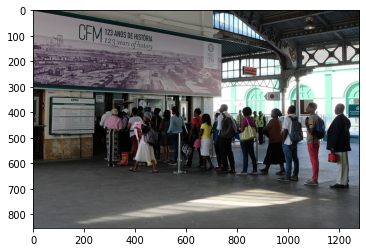

In [7]:

plt.imshow(img_np)


## Get width, height, channel of an image

In [8]:

img_h, img_w, img_c = img_np.shape
print(img_np.shape)


(853, 1280, 3)


## How an image is stored in computers.
A 3D tensor (generalization of matrix)

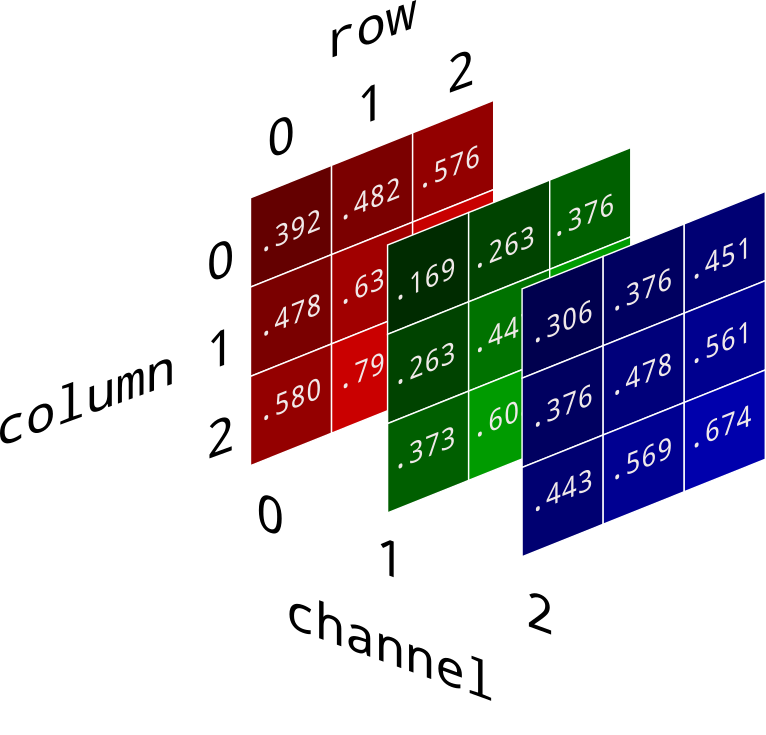


## A function to Preprocessing the image

takes in an RGB image and outputs normalized image


In [9]:

def preprocess(img):
    img = Image.fromarray(img.astype('uint8'), 'RGB')#  convert to pil image
    img = img.resize((1000, 800)) # resize to 1000 x 800 image
    img = 1.0 * np.array(img) / 255 # normalize to 0, 1
    
    img -= np.array([0.485, 0.456, 0.406]) 
    img /= np.array([0.229, 0.224, 0.225]) # z score normalization (calculated from training dataset)
        
    return img.astype(np.float32, order="C") # order "C" switchs rows and columns
    

In [10]:

input_img = preprocess(img_np)
print(input_img.shape)


(800, 1000, 3)


## Execute Job on the DPU

In [11]:

# get a runner instance on the board
dpu = overlay.runner

# get shapes of input and output of model
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

shapeIn, shapeOut, outputSize 

((1, 800, 1000, 3), (1, 100, 126, 1), 12600)

In [12]:

# create place holders for input and output because the board is expecting a list of input NOT just 1 image
output_data = [np.zeros(shapeOut, dtype=np.float32, order="C")]
input_data = [np.zeros(shapeIn, dtype=np.float32, order="C")]

# set out image in input data placeholder
input_data[0] = input_img

# execute the job on board
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)


0

In [13]:

# final count is the sum ouputs for all "key points"
final_count = np.sum(output_data[0]) 

print("The total number of people in the image are approximately: ", final_count)


The total number of people in the image in approximately:  15.3125


## Using the LED Bar



In [14]:

MAX_NUM_PEOPLE = 6000


brightness = 3  # brightness of led bars
green_to_red = 1

level = (10 * final_count) // MAX_NUM_PEOPLE # calculate level to set on ledbar
level = int(level) # requires integer


# if level is out of range (1 to 10) then set to minimum or maximum value
if(level <= 0):
    level = 1
elif(level > 10):
    level = 10

# set the level on the led bar
print("Setting LED level to:", level)
ledbar.set_level(int(level), brightness, green_to_red)



Setting LED level to: 1


The LED Bar should light up as in this picture

![ledbar_pic.png](attachment:ledbar_pic.png)


In [15]:

# clear ledbar
ledbar.clear()



## Bonus Quest

Get images from webcam input and pass them to the model.
 
Hint: refer to MNIST or YOLO notebooks.



